## Creating an object localization model to find letter bounding boxes on captcha

### **Note, this is prototype code that was written in process of creating the final object recognition that i decided to post too, mostly experimenting different approaches to solve the problem. Check out object_detection.ipynb for the full solution.

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
from tensorflow.keras.utils import  plot_model
import matplotlib.pyplot as plt
import cv2
import keras

<h2><font color='red'> Loading and preparing the images </font></h2>

In [4]:
data_dir = 'images'

In [5]:
from glob import glob
# finding all images in the folder, sort them to match xml files
all_imgs = glob(f'{data_dir}/*/*.jpg')
all_imgs = sorted(all_imgs, key=lambda x: x.split('/')[-1])  # sort by captcha name
print(f'{len(all_imgs)} images found')

150 images found


Original image shape: (70, 200, 3)
Processed image shape: (70, 200)

Original image vs. Image model takes in as input:


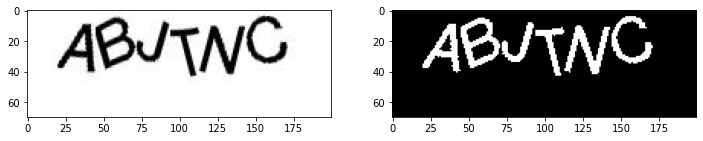

In [85]:
# showing the original and thresholded image side by side
image = cv2.imread(all_imgs[0])
gray = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
# model will take thresholded image as input
thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)[1]
print(f'Original image shape: {image.shape}')
print(f'Processed image shape: {thresh.shape}')

print('\nOriginal image vs. Image model takes in as input:')
fig = plt.figure(figsize=(12,12))
fig.add_subplot(1, 2, 1)
plt.imshow(image)
fig.add_subplot(1, 2, 2)
plt.imshow(thresh, cmap='gray')

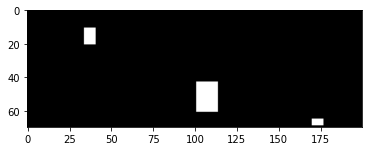

In [7]:
# my attempt of creating some images with random noise(beggining of an idea, everything would be randomized)
# to create model that learns what and where CAPTCHA is on the image.. idk
# but quickly decided that it wouldn't be neccessary... so just scrap code
test = np.zeros((70, 200, 1))
test[43:61, 101:114, :] = 1
test[11:21, 34:41, :] = 1
test[65:69, 170:177, :] = 1
plt.imshow(test, cmap='gray')

In [8]:
def prep_image(img_path):
    # processes images for the model
    image = cv2.imread(img_path)
    gray = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
    # get threshold, reshape to (x, y, 1) and normalize
    return cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)[1].reshape(70, 200, 1) / 255.0

Shape of data: (150, 70, 200, 1)


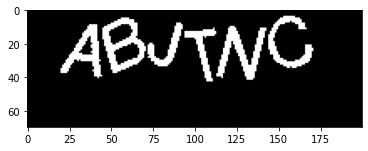

In [9]:
# go throgh all images, prepare them
data = []
for img in all_imgs:
    # prepare all images
    data.append(prep_image(img))

data = np.array(data)
print(f'Shape of data: {data.shape}')
# sanity check: plotting one image
plt.imshow(data[0], cmap='gray')

<h2><font color='red'> Loading and preparing labels </font></h2>

### Reading a sample annotated xml

In [11]:
# get all xml files, sort to match images
all_xml_paths = glob(f'{data_dir}/*/*.xml')
print(f'{len(all_xml_paths)} XML files found')
all_xml_paths = sorted(all_xml_paths, key=lambda x: x.split('/')[-1])  # sort by captcha name

150 XML files found


In [12]:
# reading is done with BeautifulSoup, easy
from bs4 import BeautifulSoup

def read_xml(path):
    # reads single xml file created by image annotation
    with open(path) as f:
        soup = BeautifulSoup(f)
        letters = soup.select('object')
        # create list that will contain the xml data
        letters_info = []
        for let in letters: 
            # extracting data for each letter
            name = let.select_one('name').text
            x_min = int(let.select_one('xmin').text) / 200.
            y_min = int(let.select_one('ymin').text) / 70.
            x_max = int(let.select_one('xmax').text) / 200.
            y_max = int(let.select_one('ymax').text) / 70.
            letters_info.append([name, x_min, y_min, x_max, y_max])
        
        return letters_info

In [13]:
from pprint import pprint

# i'll probably need to rescale all cordinates and divide them by 200
# sanity check: reading an sample xml file
test_label = read_xml(all_xml_paths[0])  # read xml
print("Labels:")
pprint(test_label)

print()
# getting only the coordinates
a = pd.DataFrame(test_label)
print("Only labels: ")
print(a.iloc[:, 1:].to_numpy())


Labels:
[['a', 0.09, 0.11428571428571428, 0.22, 0.6142857142857143],
 ['b', 0.215, 0.04285714285714286, 0.36, 0.7],
 ['j', 0.36, 0.05714285714285714, 0.47, 0.5857142857142857],
 ['t', 0.465, 0.08571428571428572, 0.565, 0.7714285714285715],
 ['n', 0.565, 0.1, 0.715, 0.7],
 ['c', 0.715, 0.04285714285714286, 0.865, 0.5285714285714286]]

Only labels: 
[[0.09       0.11428571 0.22       0.61428571]
 [0.215      0.04285714 0.36       0.7       ]
 [0.36       0.05714286 0.47       0.58571429]
 [0.465      0.08571429 0.565      0.77142857]
 [0.565      0.1        0.715      0.7       ]
 [0.715      0.04285714 0.865      0.52857143]]


### Saving labels to numpy array

In [14]:
# reading all files
labels = []

for path in all_xml_paths:
    # read xml file, convert from list to dataframe, iloc to take only coordinates, convert 
    # to numpy array and flatten it 
    read = pd.DataFrame(read_xml(path)).iloc[:, 1:].to_numpy().flatten()
    # make labels easier for model to train(divide by img width)
    labels.append(read)
    
print('Amount of labels:', len(labels))
print('Sample label:', labels[0])

# convert to numpy array
labels = np.array(labels)

Amount of labels: 150
Sample label: [0.09       0.11428571 0.22       0.61428571 0.215      0.04285714
 0.36       0.7        0.36       0.05714286 0.47       0.58571429
 0.465      0.08571429 0.565      0.77142857 0.565      0.1
 0.715      0.7        0.715      0.04285714 0.865      0.52857143]


### Checking the bounding boxes

Coordinates format: top-left and bottom-right corner ((x1, y1),(x2, y2))
Coordinates ==> top-left:(18, 8), bottom-right(44, 43)


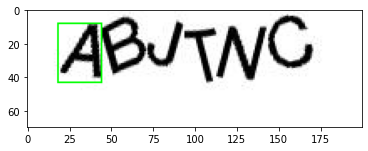

In [15]:
# sanity check: checking the bounding box of an sample letter

#same as loaded xml file
test_im_path = '/home/nocturnal/prog/PycharmProjects/CaptchaObjectDetection/images/train/ABJTNC.jpg'

im = cv2.imread(test_im_path)
top_left = (int(labels[0][0]*200), int(labels[0][1]*70))
bot_right = (int(labels[0][2]*200), int(labels[0][3]*70))
print('Coordinates format: top-left and bottom-right corner ((x1, y1),(x2, y2))')
print(f'Coordinates ==> top-left:{top_left}, bottom-right{bot_right}')

rect = cv2.rectangle(im.copy(), top_left, bot_right, (0, 255, 0), 1)
plt.imshow(rect)

In [16]:
# Since 6 letters(objects) will always appear on the image there is no need for a custom loss function
# some custom mse loss sketch
# custom_loss = (y1-y_pred1)**2 + (y2-y_pred2)**2 + (y3-y_pred3)**2
# custom_loss += (y4-y_pred4)**2 (y5-y_pred5)**2 + (y6-y_pred6)**2

<h2><font color='red'><b><u> Putting it all together: </u></b></font></h2>

## Using the pretrained model to extract features from the image, then stacking a dense layer to predict(with regression) bounding boxes of each letter

## Testing the pretrained(with weights) model previously used for letter classification:

In [2]:
# Loading the pretrained model and removing all of the Dense layers leaving only Conv2D layers
model = keras.models.load_model('model.hdf5')
print('Original model summary:\n')
model.summary()

model.pop()
model.pop()
model.pop()
model.pop()
model.pop()
model.pop()

print('\nLast layers are removed - new summary:\n')
model.summary()

Original model summary:

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 20)        520       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 40)        20040     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 40)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        64064     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (N

In [3]:
# Loading a pretrained saved model and using it for feature extraction
# Input shape that the new model will have
inputs = keras.Input(shape=(70, 200, 1))
# Need to change the input shape of the original model - also converts it to tensor
model = model(inputs, training=True)

# Old model needs to be of 'tensor' type in order for this to work: adding new output layers
x = Flatten()(model)
x = Dense(128, activation='relu')(x)
x = Dense(24)(x)
print(f'The type is {type(x)}')

# Creating a new model with the functional API
new_model = Model(inputs, x)
new_model.summary()

The type is <class 'tensorflow.python.framework.ops.Tensor'>
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 70, 200, 1)]      0         
_________________________________________________________________
sequential (Sequential)      (None, 6, 6, 64)          84624     
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1638528   
_________________________________________________________________
dense_1 (Dense)              (None, 24)                3096      
Total params: 1,726,248
Trainable params: 1,726,248
Non-trainable params: 0
_________________________________________________________________


In [17]:
# using MSE loss
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import RMSprop, SGD, Adam

new_model.compile(loss='mse', optimizer=SGD())
new_model.fit(data[:140], labels[:140], batch_size=8, epochs=10, verbose=1)

# dense output layer will need to have (num of letters)x(coordinates) = 6*4 = 24 units

Epoch 1/10
18/18 [==============================] - 0s 8ms/step - loss: 0.0948
Epoch 2/10
18/18 [==============================] - 0s 7ms/step - loss: 0.0139
Epoch 3/10
18/18 [==============================] - 0s 7ms/step - loss: 0.0036
Epoch 4/10
18/18 [==============================] - 0s 7ms/step - loss: 0.0014
Epoch 5/10
18/18 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 6/10
18/18 [==============================] - 0s 6ms/step - loss: 9.4040e-04
Epoch 7/10
18/18 [==============================] - 0s 6ms/step - loss: 9.1791e-04
Epoch 8/10
18/18 [==============================] - 0s 7ms/step - loss: 9.0476e-04
Epoch 9/10
18/18 [==============================] - 0s 6ms/step - loss: 8.9415e-04
Epoch 10/10
18/18 [==============================] - 0s 7ms/step - loss: 9.0383e-04


In [ ]:
# test images dir
eval_img_path = 'images/test/BATMYG.jpg'

# image needs to be preprocessed and reshaped before evaluation
test_image = prep_image(eval_img_path)
test_image = test_image.reshape(1, 70, 200, 1)

print('Test image: ')
plt.imshow(test_image[0], cmap='gray')

In [19]:
# predicting bounding boxes
prediction = new_model.predict(test_image)

# scaling the coordinates back
p = [i*200 if n % 2 == 0 else i*70 for n, i in enumerate(prediction[0])]
print(f'Predicted coordinates: \n {p}')

Predicted coordinates: 
 [18.426477909088135, 6.6422732919454575, 49.87313747406006, 43.22658181190491, 51.0780930519104, 2.0004318468272686, 75.96368789672852, 38.389129638671875, 75.80671906471252, 2.37588569521904, 100.69804191589355, 42.74748623371124, 103.38354110717773, 7.738372832536697, 130.52290678024292, 44.50982213020325, 131.71586990356445, 1.6756229847669601, 153.70773077011108, 40.62124848365784, 149.49229955673218, 3.9556774124503136, 187.79314756393433, 39.00512754917145]


In [20]:
def draw_rects(image, coords):
    """
    param image: numpy array(image)
    param cords: bounding boxes coordinates
    draws bounding boxes over the image
    """
    rect = image.copy()
    for i in range(int(len(coords)/4)):
        top_left = (int(coords[(i*4)+0]), int(coords[(i*4)+1]))
        bot_right = (int(coords[(i*4)+2]), int(coords[(i*4)+3]))
        rect = cv2.rectangle(rect, top_left, bot_right, (0, 255, 0), 1)

    return rect

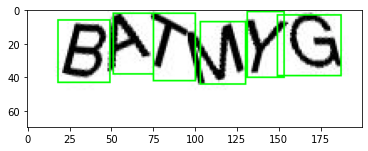

In [21]:
# testing on a sample image
pred_img = cv2.imread(eval_img_path)
pred_img = draw_rects(pred_img, p)

# plotting predicted bounding boxes
plt.imshow(pred_img, cmap='gray')

## Creating a quick new model and testing it

In [46]:
from tensorflow.keras.layers import Conv2D, Dropout
from tensorflow.keras import Sequential

model4 = Sequential()
model4.add(Conv2D(32, activation='relu', kernel_size=(3, 3), input_shape=(70, 200, 1)))
model4.add(Conv2D(32, activation='relu', kernel_size=(3, 3), strides=(2, 2)))

model4.add(Conv2D(64, activation='relu', kernel_size=(3, 3)))
model4.add(Conv2D(64, activation='relu', kernel_size=(3, 3), strides=(2, 2)))

model4.add(Dropout(0.3))
model4.add(Conv2D(128, activation='relu', kernel_size=(3, 3)))
model4.add(Conv2D(128, activation='relu', kernel_size=(3, 3), strides=(2, 2)))

model4.add(Flatten())
# model4.add(Dense(128, activation='relu'))
model4.add(Dense(24))

model4.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 68, 198, 32)       320       
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 33, 98, 32)        9248      
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 31, 96, 64)        18496     
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 15, 47, 64)        36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 47, 64)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 13, 45, 128)       73856     
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 6, 22, 128)       

In [47]:
# Training on 8 epochs using Adam with a slightly reduced learning rate
model4.compile(loss='mse', optimizer=Adam(lr=0.0008))
model4.fit(data, labels, batch_size=8, epochs=8, verbose=1)

Epoch 1/8
19/19 [==============================] - 0s 10ms/step - loss: 0.1178
Epoch 2/8
19/19 [==============================] - 0s 11ms/step - loss: 0.0132
Epoch 3/8
19/19 [==============================] - 0s 11ms/step - loss: 0.0019
Epoch 4/8
19/19 [==============================] - 0s 11ms/step - loss: 9.7069e-04
Epoch 5/8
19/19 [==============================] - 0s 11ms/step - loss: 7.5631e-04
Epoch 6/8
19/19 [==============================] - 0s 11ms/step - loss: 7.4556e-04
Epoch 7/8
19/19 [==============================] - 0s 11ms/step - loss: 7.3195e-04
Epoch 8/8
19/19 [==============================] - 0s 11ms/step - loss: 6.8457e-04


### Copying previous code for image validation(with some slight adjustments)

Predicted coordinates: 
 [20, 6, 48, 40, 48, 2, 73, 36, 73, 2, 98, 39, 97, 6, 118, 42, 118, 3, 142, 37, 142, 1, 169, 36]


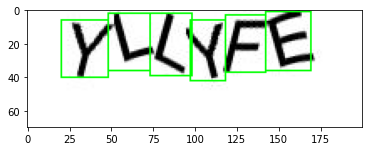

In [70]:
# predicting bounding boxes
t = data[141].reshape(1, 70, 200, 1)
prediction = model4.predict(t)

# scaling the coordinates back
p = [int(i*200) if n % 2 == 0 else int(i*70) for n, i in enumerate(prediction[0])]
print(f'Predicted coordinates: \n {p}')

# testing on a sample image (data[141] in this case)
pred_img = cv2.imread([i for i in all_imgs if 'YLLYFE' in i][0])
pred_img = draw_rects(pred_img, p)

# plotting predicted bounding boxes
plt.imshow(pred_img, cmap='gray')

In [77]:
from math import ceil, floor

# Implementing a custom round function since int conversion only rounds down no matter the fractional part
def my_round(num, thresh=0.2):
    """
    rounds the number up if its fractional point is above custom threshold, default is (0.2)
    """
    up = ceil(num)
    if up - num > thresh: 
        return up
    else:
        return floor(num)

[20, 5, 48, 40, 47, 2, 73, 36, 72, 2, 98, 38, 97, 5, 117, 42, 117, 2, 141, 37, 142, 1, 169, 36]


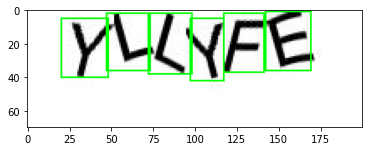

In [81]:
# Reusing the code... Checking for differences
p = [my_round(i*200) if n % 2 == 0 else my_round(i*70) for n, i in enumerate(prediction[0])]
pred_img = cv2.imread([i for i in all_imgs if 'YLLYFE' in i][0])
pred_img = draw_rects(pred_img, p)

# plotting predicted bounding boxes
plt.imshow(pred_img, cmap='gray')
print(p)

In [83]:
print(38-37.8)  # funny stuff :)

0.20000000000000284


### Trying out VGG16(not good enough)

In [601]:
vgg = tf.keras.applications.VGG16(input_shape=[70, 200, 3], weights='imagenet', include_top=False)

# Freezing the layers
for layer in vgg.layers:
    layer.trainable = False

# Adding on 3 dense layers(including the output layer)
xs = Flatten()(vgg.output)
xs = Dense(128, activation='relu')(xs)
xs = Dense(64, activation='relu')(xs)
xs = Dense(24)(xs)
model3 = Model(vgg.input, xs)
model3.compile(loss='mse', optimizer=RMSprop())
model3.summary()

Model: "functional_97"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_56 (InputLayer)        [(None, 70, 200, 3)]      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 70, 200, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 70, 200, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 35, 100, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 35, 100, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 35, 100, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 17, 50, 128)     

In [550]:
def vgg_prep(img_path):
    # processes images for the model
    return cv2.imread(img_path) / 255.0

In [551]:
vgg_data = []
for i in all_imgs:
    vgg_data.append(vgg_prep(i))
    
print(f'No. of images: {len(vgg_data)}')
vgg_train = np.asarray(vgg_data[:140])

No. of images: 150


In [552]:
print(vgg_train.shape)

(140, 70, 200, 3)


In [602]:
model3.fit(vgg_train, labels[:140], batch_size=8, epochs=10, verbose=1)

Epoch 1/10
18/18 [==============================] - 1s 46ms/step - loss: 0.1786
Epoch 2/10
18/18 [==============================] - 1s 45ms/step - loss: 0.0304
Epoch 3/10
18/18 [==============================] - 1s 45ms/step - loss: 0.0173
Epoch 4/10
18/18 [==============================] - 1s 45ms/step - loss: 0.0226
Epoch 5/10
18/18 [==============================] - 1s 45ms/step - loss: 3.6285
Epoch 6/10
18/18 [==============================] - 1s 45ms/step - loss: 0.0769
Epoch 7/10
18/18 [==============================] - 1s 45ms/step - loss: 0.0636
Epoch 8/10
18/18 [==============================] - 1s 45ms/step - loss: 0.0723
Epoch 9/10
18/18 [==============================] - 1s 45ms/step - loss: 0.0467
Epoch 10/10
18/18 [==============================] - 1s 45ms/step - loss: 0.0652


In [603]:
# Using the same code, however this time image has 3 channels instead of previous 3
pred = model3.predict(vgg_data[141].reshape(1, 70, 200, 3))
p = [i*200 if n % 2 == 0 else i*70 for n, i in enumerate(pred[0])]
print(p)

[-31.736421585083008, -0.2973697613924742, 73.0151891708374, 25.9818634390831, -17.211022973060608, -0.30847838148474693, 69.5152223110199, 31.472161412239075, 90.76197147369385, 5.536745861172676, 143.9961552619934, 65.3795713186264, 133.63012075424194, 6.340295523405075, 188.10946941375732, 42.432867884635925, 111.41728162765503, 19.79657918214798, 149.22080039978027, 41.70220613479614, 209.64422225952148, -4.584059566259384, 214.12911415100098, 39.624271392822266]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


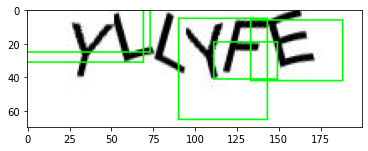

In [604]:
pred_img = draw_rects(vgg_data[141], p)
plt.imshow(pred_img)

### Although this example of using VGG16 is pretty bad, multiple arhitectures of VGG16 vere used previously - including diferent optimizers, loss functions, layers, ... And neither of them showed satisfying results. So a custom model is the way to go.

In [131]:
j = cv2.threshold(data[120].copy(), 127, 255, cv2.THRESH_BINARY_INV)[1]
j = np.array(j, dtype='uint8')
cnts, _ = cv2.findContours(j.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
